# CF contributions from SHAP contributions and Dichotomous search

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.model_selection import train_test_split
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
import pickle

from numpy import savetxt

from sklearn.ensemble import StackingRegressor

In [9]:

ledataset=pd.read_csv('data/ledataset_imputed.csv')

#standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_scaled= scaler.fit_transform(ledataset.values)
df= pd.DataFrame(df_scaled, columns=ledataset.columns)

#Divide dataset in train and test set
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape,y_train.shape,X_test.shape, y_test.shape

((11624, 52), (11624,), (2907, 52), (2907,))

In [10]:
import os 
print(os.getcwd())
# load model
filename = "model/ols_meta.pickle" #if you execute from jupyter
#filename = "outputs/meta/ols_meta.pickle" # if you execute in cmd
model = pickle.load(open(filename, "rb"))
model

/home/pamela/Bureau/workspaceDjango/cri2025/lecode/cfLSMeta/to_publish


StackingRegressor(cv=KFold(n_splits=10, random_state=100, shuffle=True),
                  estimators=[('xg',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance...
                               MLPRegressor(batch_size=500, early_stopping=True,
                                            hidden_layer_sizes=(500, 1000, 500),
                                            learning_rate='adaptive',
                                            max_iter=100)),
                              ('knn',
                               KNeighborsRegressor(algorithm='brute', n_jobs=-1,
                                                   n_neighbors=4, p=1,
                                                   weights='distance')),
                              ('ols', LinearRegression()),
                              ('elasticnet',
                               ElasticNet(alpha=2, l1_ratio=0, max_iter=2000))],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=3)

In [11]:
from numpy import mean
from numpy import std
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#prediction
pred=model.predict(X_test)

#compute metrics
mae=mean_absolute_error(y_test,pred)
r2= r2_score(y_test, pred)

print('MAE: %.3f'%mae)
print("r^2: %.3f" %r2)

MAE: 0.116
r^2: 0.857


In [12]:
#check the actual path 
print(os.getcwd())

/home/pamela/Bureau/workspaceDjango/cri2025/lecode/cfLSMeta/to_publish


In [13]:
# import contributions 
shap_contributions= np.loadtxt('explainer/shap_contributions_test.csv',delimiter=';')
print("CONTRIBUTIONS shape\n","\nshap : ",shap_contributions.shape)

CONTRIBUTIONS shape
 
SHAP :  (2907, 52)


In [14]:
# methods to get tuples
import itertools

#Method A
def get_k_largest_important_feats(contrib,k=3):
    abs_contrib= [abs(elt) for elt in contrib] 
    k_largest_features_index = np.argsort(abs_contrib)[-k:][::-1]
    return k_largest_features_index

# Here we applying restriction before generating combinations
def get_restricted_tuples_feat(k_features, max_size, restricted=None):
    '''Return the differents tuples of max_size wich containing elements in restricted list
        By default restricted list contains the two first elements in k_features'''    
    
    if restricted is None:
        restricted = k_features[:2]  # default first two elements

    rest = [x for x in k_features if x not in restricted]
    results = []
    results = [tuple([x]) for x in restricted]
  
    for taille in range(len(restricted), max_size + 1):
        r = taille - len(restricted)
        if r < 0: #here
            results[taille] = []
            continue
       
        for combo_rest in itertools.combinations(rest, r):
            combo = tuple(restricted) + combo_rest
            results.append(combo)

    return results

# Methode B
def get_k_ranking_feats(obs,contrib,X_background, increase_pred,k):
    print("______Function : -- get_k_ranking_feats --")
    cf_x = obs.copy()
    new_contrib = []
    for i,c in enumerate(contrib) :
        cf_init_mixed = init_CF_with_tuples (X_background,contrib,tuple([i]), cf_x, increase_pred)
        val =abs(abs(cf_init_mixed[i]- obs[i]) * c)
        new_contrib.append(val)
    print(f"normal ranking : {get_k_largest_important_feats(contrib,k)}")
    print(f"new ranking : {get_k_largest_important_feats(new_contrib,k)}")
   
    k_largest_features_index = np.argsort(new_contrib)[-k:][::-1]
    return k_largest_features_index

def get_first_ones_tuples_feat(k_feat, max_size):
    '''Return the differents tuples of max_size, at each step provide the first one tuple only'''
    
    resultat = []
    k_features = [x[0] for x in k_feat]
    for taille in range(2, max_size + 1):
        combo_iter = itertools.combinations(k_features, taille)
        try:
            first_combo = next(combo_iter)
            resultat.append(first_combo)
        except StopIteration:
            # Not enough elements for this size
            pass
        
    return resultat

In [15]:
def init_CF_with_tuples (X_background,contrib,tuple_feat, cf, increase_pred):
    
    neg_impact = []
    pos_impact=[]
    print(f"tuple: {tuple_feat}")
    cf_x = cf.copy()
    #print(cf.index)
    if(tuple_feat):
        for j in range(0,len(tuple_feat)):
            feat_index = tuple_feat[j]
            print(f"feat_index :{feat_index}")
            minim =X_background[X_background.columns[feat_index]].min()
            maxi =X_background[X_background.columns[feat_index]].max()
            print(f"  ---- {X_background.columns[feat_index]}, index : {feat_index}, "+ 
              f"min ={minim}, to_increase = {increase_pred} "+f"contrib = {contrib[feat_index]}"
              f"max = {maxi}, cf_x before = { cf_x.iloc[feat_index]}")
            
            if(increase_pred == True): #test if the y_expected is greater than the y_pred
                #print(f"if: contrib[feat_index] = {contrib[feat_index]}")
                if (contrib[feat_index] >0) :
                    pos_impact.append(feat_index)
                    #print(type(cf_x))
                    cf_x.iloc[feat_index] = maxi
                    #print(f"   positive impact : contrib = {contrib[feat_index]}")
                elif (contrib[feat_index] <0) :
                    neg_impact.append(feat_index)
                    cf_x.iloc[feat_index]= minim
                    #print(f"   negative impact : contrib = {contrib[feat_index]}")
                else:
                    print(f"contrib[{feat_index}] == 0")
                    
                #print(f"INIT CF : cf_x = {cf_x.iloc[feat_index]}, to_increase = {increase_pred}")
            elif (increase_pred == False):
                if contrib[feat_index] <0 :
                    pos_impact.append(feat_index)
                    cf_x.iloc[feat_index]= maxi
                    #print(f"   negative impact : contrib = {contrib[feat_index]}")
                elif contrib[feat_index] >0 :
                    neg_impact.append(feat_index)
                    cf_x.iloc[feat_index]= minim
                    #print(f"   positive impact : contrib = {contrib[feat_index]}")
                else:
                    print(f"contrib[{feat_index}] == 0")
                #print(f"INIT CF : cf_x = {cf_x.iloc[feat_index]}, to_increase = {increase_pred}")
            print(f"RESULTS INIT CF: cf_x = {cf_x[feat_index]},  to_increase = {increase_pred}")
    return cf_x

In [16]:
#Some useful methods

def min_round(a, b, max_decimals=10):
    for d in range(1, max_decimals + 1):
        if round(a, d) != round(b, d):
            return d
    return None  # too close, or identical up to max_decimals

def min_decimal_places(a, b, max_decimals=10):
    for d in range(1, max_decimals + 1):
        if not a.round(d).equals(b.round(d)):
            continue
        return d
    return max_decimals  # fallback if no match earlier

def display_ob (ob):
    df= ob.to_frame().T
    return  df.to_string(index=False)

#get counterfatuals by applying dichotomous logic 
def compute_dicho_cf(ob, contrib, X_background, y_expected,model, eps, tuples_feat,to_increase_pred):
        # step 3.1
        pred = ob[-1]
        obs= ob.iloc[:-1].copy()
        cfs_ok=[]
        y_cfs_ok=[]
        tuples_changing_pred = []
        tuples_not_changing_pred = []
        cf_changing_pred = pd.DataFrame()
        cf_not_changing_pred = pd.DataFrame()
       
        print("_________Function : -- compute_dicho_cf --")
        for i in range(0,len(tuples_feat)):
            x=obs.copy() 
            cf_x = obs.copy()
            tup = tuples_feat[i]
            #print(f"increase pred = {to_increase_pred}")
            cf_x = init_CF_with_tuples (X_background,contrib,tup,cf_x, to_increase_pred)
            y_cf =model.predict(np.array([cf_x]))# model(np.array(cf_x),coefs)
            print (f"abs init (y_expected (={y_expected})- y_cf(={y_cf})) = {abs((y_expected-y_cf))}")
            if(to_increase_pred==True):
                if(y_cf<y_expected):
                    print(f"can't iterate for feature {i}")
                    continue
            else:
                if(y_cf>y_expected):
                    print(f"can't iterate for feature {i}")
                    continue 
            #print (f" x_init: \n{display_ob(x)}"+f"\n cf_init: \n{display_ob(cf_x)}")
            cpt=-1
            if (abs(y_expected - y_cf)) <= eps :
                cf_feat = cf_x
                cpt=0
            else :
                cpt=1

            while (abs(y_expected - y_cf)) >= eps :
                #to avoid to iterate if x and cf_x are two close (2 decimal digits)
                #round_val = min_round()
                if(x.reset_index(drop=True).round(6).equals(cf_x.reset_index(drop=True).round(6)) 
                       and x.name == cf_x.name):
                    print(f"STOP! \t X and CF_x are equals or too closer (after 6 decimal digits)")
                    break

                print(f"\niter : {cpt+1}")
                x_middle=obs.copy()
                for f_index in tup: #change middle of each feature in tuple
                    middle= (x[f_index] + cf_x[f_index])/2
                    x_middle[f_index]=middle
                    #print(f"val feat_middle= {x_middle[f_index]} for index {f_index}")
                #print(f"new x_middle= {np.array(x_middle)}")
                y_middle=model.predict(np.array([x_middle]))# model(np.array(x_middle),coefs)
                #print(f"y_middle = {y_middle}")        

                if y_expected < y_middle:
                    if(to_increase_pred):
                        cf_x= x_middle.copy()
                    else:
                        x= x_middle.copy()
                elif y_expected > y_middle:
                    if(to_increase_pred):
                        x= x_middle.copy()
                    else: 
                        cf_x= x_middle.copy()
                else:
                    cf_x= x_middle.copy()

                y_x =model.predict(np.array([x]))# model(np.array(x),coefs)
                y_cf = model.predict(np.array([cf_x]))#model(np.array(cf_x),coefs)
                print (f"abs (y_ex-y_cf)= {abs(y_expected-y_cf)}\n")# x =\n{display_ob(x.iloc[list(tup)])} |" +
                     # f"\ncf_x =\n{display_ob(cf_x.iloc[list(tup)])}")        
                cf_feat = cf_x
                cpt=cpt+1
            if(obs.reset_index(drop=True).equals(cf_x.reset_index(drop=True)) 
                       and obs.name == cf_x.name):
                cf_feat =None
                print(f"For feature {X_background.columns[list(tup)]}\n Val_init :{display_ob(obs)}\n"+ 
                            "CF not valid because cf == initial observation")
                tuples_not_changing_pred.append(tup)
                continue
                
            if(cpt==-1):
                cf_feat =None
                #print(f"For feature {X_background.columns[list(tup)]}\n Val_init :{display_ob(obs)}\n"+ 
                 #           "CF not found")
                print(f"For feature {X_background.columns[list(tup)]}"+ "CF not found")
                continue
           
            else :
                y_cf = model.predict(np.array([cf_feat]))[0]#model(np.array(cf_feat),coefs)
                #y_cf = round(y_cf, 2)
                cfs_ok.append(cf_feat)
                y_cfs_ok.append(y_cf)

              #  print(f"For feature {X_background.columns[list(tup)]}\n Val_init :\n{display_ob(obs)}\n"+ 
               #   f"CF found : Val_CF :\n{display_ob(cf_x)}, y_cf :{y_cf}, (y_ex - y_cf) ={y_expected - y_cf}")
                print(f"For feature {X_background.columns[list(tup)]}\n "+ 
                 f"CF found , y_cf :{y_cf}, (y_ex - y_cf) ={y_expected - y_cf}")

            features=cf_feat.copy().round(3)
            full_row = features.append(pd.Series({X_background.columns[-1]: round(y_cf, 3)}))
            if((abs(y_expected - y_cf)) <= eps):
                #print(f"CF PREDICTION HAS REACHED Y_expected with threshold = {eps}")
                tuples_changing_pred.append(tup)
                if cf_changing_pred.empty:
                    cf_changing_pred = pd.DataFrame(columns=full_row.index)
                cf_changing_pred.loc[len(cf_changing_pred)] = full_row

            else:
                #print(f"CF PREDICTION HAS NOT REACHED Y_expected with threshold = {eps}")
                tuples_not_changing_pred.append(tup)
                if cf_not_changing_pred.empty:
                    cf_not_changing_pred = pd.DataFrame(columns=full_row.index)
                cf_not_changing_pred.loc[len(cf_not_changing_pred)] = full_row


        #print(f"{len(cfs_ok)} counterfactuals calculated for  --- obervation --- \n")
        print(f"Tup reaching y_ex : {tuples_changing_pred} \nTup not reaching y_ex : {tuples_not_changing_pred}") 

        #build dataframe of each CF calculated
        df_cf = pd.DataFrame(cfs_ok)
        df_cf[X_background.columns[-1]]=y_cfs_ok 

        return df_cf,tuples_changing_pred,tuples_not_changing_pred,cf_changing_pred,cf_not_changing_pred

In [17]:
#by default we fix eps = 0.01, k=3

def dicho_cf_test (ob, contrib, X_background, y_expected,model, eps = 0.01, k=3):
    """
    Find a Counterfactual cf such that f(cf) ≈ y_expected in an interval [min/val, max/val] providing by a
    background data using dichotomic algorithm

    f : model
    epsilon : precision
    k: number of features to modify to obtain CF
    contrib : contributions values for each features
    X_background : background data 
    y_expected : desired output
    """
    final_result=None
    pred = ob[-1]
    obs= ob.iloc[:-1].copy()
    print(f"obs.shape == {obs.shape}")
    if(k>len(obs)):
        print("k is out of range")
        return
    print(f" TOP-{k}: ")
        
    if (pred - y_expected)<0: #we want to increase prediction
            print(f"* INCREASE PRED * : output = {pred} < desired output ={y_expected}")
            to_increase_pred = True
    elif (pred - y_expected)>0: #we want to reduce prediction
            print(f"* DECREASE PRED * : output = {pred} > desired output ={y_expected}")
            to_increase_pred = False
    
    ranking="normal"#"normal"
    #print("... get ranking of features ....")
    if(ranking == "normal"):
        #print(" \tNormal ranking is choose ")
        k_largest_features_index = get_k_largest_important_feats(contrib,k)
    else:
        #print(" \tour proposal ranking is choose ")
        k_largest_features_index = get_k_ranking_feats(obs,contrib,X_background,to_increase_pred,k)
    print("... end ranking of features .... \n")
   
    #print(f"Computing CF for each feat ...")
    #1.get first tuples of size one
    tuples_feat=[tuple([x]) for x in k_largest_features_index] 
    print(tuples_feat)
    #print(f"to_increase_pred = {to_increase_pred}")
    #send them to compute CF
    r = compute_dicho_cf(ob, contrib, X_background, y_expected, model,eps,tuples_feat,to_increase_pred)
    #return r
    if (k==1):
        print("k==1")
        return r[3]
    
    #2. from  r get tuples which reach target
    feats_reaching = r[1]
    #then from feats_reaching compute new tuples of size [2, ..., k] by retaining only the first combinaison : 
    if (ranking != "normal"):
        if(feats_reaching):
            #print(f"METHOD WITH ONLY FEAT THAT CHANGES PRED ALONE")
            #print(f"features reaching y_expected alone: \n{feats_reaching}")
            #print(f"Cfs found for them: \n{r[3]}")
            final_result = r[3]
            if(len(feats_reaching)>1):
                tup_reaching = get_first_ones_tuples_feat(feats_reaching, k)
                #tup_reaching = get_restricted_tuples_feat(feats_reaching, k)#ALSO POSSIBLE TO RESTRICT THOSE CHANGING ALONE
                print(f" tup_reaching_test :{tup_reaching}")
                res = compute_dicho_cf(ob, contrib, X_background, y_expected, model,eps,tup_reaching,to_increase_pred)
                final_result = pd.concat([r[3],res[3]],ignore_index=True)
        else :
            #print(f"METHOD WITH ALL IMPORTANT FEATs with restriction")
            #print(f" feats_reaching is empty :{feats_reaching}. Let's use All important feats with restriction")
            tup_restricted = get_restricted_tuples_feat(k_largest_features_index, k)
            tup_restricted = [t for t in tup_restricted if len(t) > 1]
            #print(f" tup_restricted_test :{tup_restricted}")
            res = compute_dicho_cf(ob, contrib, X_background, y_expected, model,eps,tup_restricted,to_increase_pred)
            final_result = pd.concat([r[3],res[3]],ignore_index=True)
    else :
        #print(f"METHOD WITH ALL IMPORTANT FEATs with restriction")
        tup_restricted = get_restricted_tuples_feat(k_largest_features_index, k)
        tup_restricted = [t for t in tup_restricted if len(t) > 1]#supp. les tuples de taille 1 dans tup_res
        #print(f" tup_restricted_test :{tup_restricted}")
        res = compute_dicho_cf(ob, contrib, X_background, y_expected, model,eps,tup_restricted,to_increase_pred)
        final_result = pd.concat([r[3],res[3]],ignore_index=True)#r[3] tuples which changes pred
        
    print("\nFinal results\n")
    if(not final_result.empty):
        #final_result
        print(f"{len(final_result)} CF(s) found :")
        return final_result
    else:
        print(f" CF(s) not found :")
        return None

In [18]:
#Reconstitute test dataset with X_test and y_test to generate CF
X_test_y_test = X_test.copy()
X_test_y_test[y_test.name] = y_test.copy()
X_test_y_test = X_test_y_test.reset_index(drop = True)
background_train = X_train.copy() 
background_train [y_train.name] = y_train.copy()

np.random.seed(42) 
noise = np.random.normal(0, 1, size=y_test.shape)# add gaussian noise
y_test_noisy = y_test + noise
(y_test,y_test_noisy)

(13812   -0.269608
 13675   -0.128892
 10411   -0.263991
 8681    -0.118665
 1220    -0.259534
            ...   
 8889    -0.205806
 13191   -0.033468
 2823    -0.265086
 9225    -0.240933
 1353    -0.124493
 Name: CO2EquivalentEmissionsTotal, Length: 2907, dtype: float64,
 13812    0.227106
 13675   -0.267156
 10411    0.383697
 8681     1.404364
 1220    -0.493687
            ...   
 8889    -0.775639
 13191    0.296041
 2823    -1.782259
 9225     0.509647
 1353    -0.540687
 Name: CO2EquivalentEmissionsTotal, Length: 2907, dtype: float64)

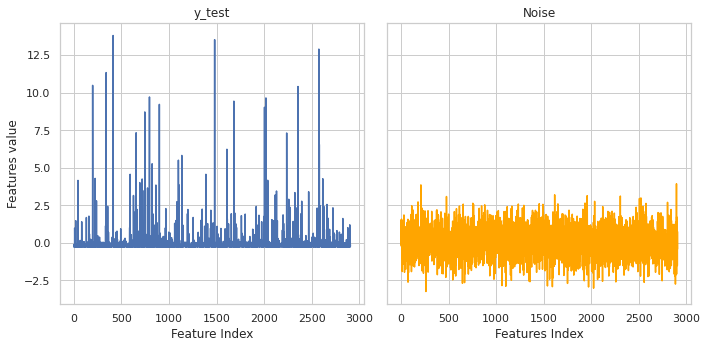

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid") #darkgrid ticks
# Sample data

df = pd.DataFrame({
    'Index': np.arange(len(y_test)),
    'y_test': y_test,
    'noise': noise,
    'y_test_noisy': y_test_noisy
})

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot y_train
sns.lineplot(x='Index', y='y_test', data=df, ax=axs[0], color='b')
axs[0].set_title('y_test')
axs[0].set_xlabel('Feature Index')
axs[0].set_ylabel('Features value')

# Plot noise
sns.lineplot(x='Index', y='noise', data=df, ax=axs[1], color='orange')
axs[1].set_title('Noise')
axs[1].set_xlabel('Features Index')
axs[1].set_ylabel('')

# Plot y_train + noise
#sns.lineplot(x='Index', y='y_test_noisy', data=df, ax=axs[2], color='g')
#axs[2].set_title('y_test + Noise')
#axs[2].set_xlabel('Features Index')
#axs[2].set_ylabel('')

plt.tight_layout()

plt.savefig("y_test_and_noise.png")
plt.show()

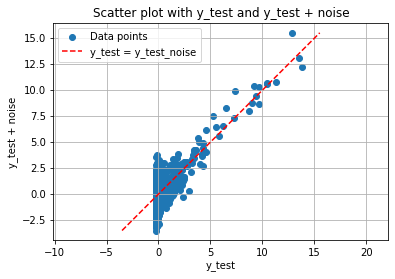

In [82]:
y1 = y_test
y2 = y_test_noisy

# Scatter plot
plt.scatter(y1, y2, label='Data points')

# Add y1 = y2 line
min_val = min(min(y1), min(y2))
max_val = max(max(y1), max(y2))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y_test = y_test_noise')

# Labels and legend
plt.xlabel('y_test')
plt.ylabel('y_test + noise')
plt.title('Scatter plot with y_test and y_test + noise')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensures aspect ratio is 1:1
plt.savefig("scatter_plot_with_noise")
plt.show()


In [19]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

class CFevaluation :
    '''Metrics are compute accorting to Dice paper'''
    
    def __init__(self, y_expected = None, threshold=None):
        self.y_expected = y_expected
        self.threshold = threshold
       
    def diversity(self,cfs,metric='euclidean'):
        '''get diversity using pairwise distance of CFs
                metric (str): Distance metric (e.g., 'euclidean', 'cityblock', 'cosine', 'hamming').'''
        from scipy.spatial.distance import cdist
        cf_array = np.array(cfs.iloc[:,:-1])
       
        if len(cf_array) < 2:
            return {"Diversity":0.0}  # No diversity with fewer than 2 counterfactuals
        # Compute pairwise distances
        distances = cdist(cf_array, cf_array, metric=metric)
        # Extract upper triangle (without diagonal) to avoid double-counting
        upper_tri_indices = np.triu_indices(len(cf_array), k=1) #k=1 → tells NumPy to skip the diagonal (where i = j)
        pairwise_distances = distances[upper_tri_indices]
        
        return {"Diversity":np.mean(pairwise_distances)}# because pairwise_distances has exactly Combinaison(2,k) = 2/(k*(k-1)) elts

    
    def diversity_std(self,x,cfs):
        if cfs.shape[0] == 0:
            return 0.0
        return {"Diversity_std":np.mean(np.std(cfs.iloc[:,:-1], axis=0))}
        
    def proximity(self,x, cfs):
        '''get proximity score using L2-norm '''
        dist_x_cfs = []
        dist_y_cf_y= []
        for i,cf in cfs.iterrows() :     
            distance = np.linalg.norm(x.iloc[:-1] - cf.iloc[:-1], ord=2) #on input level (btw les CFs) 
            dist_x_cfs.append(distance)
            print(distance)
            dist_y_cf_y.append(abs(x.iloc[-1] - cf.iloc[-1]))  # on output level (btw y)
           
        proximity_inputs =np.mean(dist_x_cfs) 
        proximity_outputs =np.mean(dist_y_cf_y) 
        return {"Proximity_input":proximity_inputs, "Proximity_output":proximity_outputs }
    
    def sparsity (self,x, cfs):
        '''get the ratio of the number of features that changed in CF list. 
                    ratio_sp * 100, to have in percentage'''
        nb_sp=[]
        ratio_sp=[]
        for i,cf in cfs.iterrows():
            bool_sp = (x.iloc[:-1] != cf.iloc[:-1])
            nb_sp.append(np.sum(bool_sp))
            ratio_sp.append(np.mean(bool_sp))
        return {"Sparsity_ratio":np.mean(ratio_sp), "Sparsity_nb":np.mean(nb_sp)}
    
    def sparsity_dice (self,x, cfs):
    
        sparsity = 0
        for i,cf in cfs.iterrows():
            sp = (x.iloc[:-1] != cf.iloc[:-1])
            sparsity =  sparsity + sp.sum()
        return{"Sparsity_dice": (1- (sparsity/(len(cfs)*(len(cfs.iloc[0])-1)))) }
                
    def validity (self,x, cfs):
        '''Return the ratio of valid cf inside the list of CFs generated'''
        valid_cf = 0
        size_cf = len(cfs)
        if(self.threshold):
            for i,cf in cfs.iterrows():
                if (round(self.y_expected - cf[-1],3)) <= self.threshold:
                    valid_cf = valid_cf + 1
        else:
            for i,cf in cfs.iterrows():
                if (self.y_expected == cf[-1]) :
                    valid_cf = valid_cf + 1
                    
        return {"Validity_ratio":(valid_cf/size_cf),"Valid_nb":valid_cf}
    
    def evaluate_all (self,x,cfs):
        print("evaluate validity, proximity, sparsity and diversity")
        print("Proximity:", self.proximity(x, cfs), type(self.proximity(x, cfs)))
        print("Sparsity:", self.sparsity(x, cfs), type(self.sparsity(x, cfs)))
        print("Diversity:", self.diversity(cfs), type(self.diversity(cfs)))
        print("Validity:", self.validity(x, cfs), type(self.validity(x, cfs)))

        r = {**self.proximity(x,cfs),**self.sparsity(x,cfs), **self.diversity(cfs),
            **self.validity(x,cfs)  #["validity_ratio"], 
        }  
        
        return pd.DataFrame([r])

In [21]:
X_test_y_test.iloc[412:420]

,group_ric,ESGControversiesScore,SocialPillarScore,GovernancePillarScore,EnvironmentalPillarScore,EmissionsScore,CSRStrategyScore,ProductResponsibilityScore,HumanRightsScore,RenewableEnergyUse,...,TotalShareholdersEquityincl,RevenuefromBusinessActivities,TotalDebtPercentageofTotalE,LongTermDebtPercentageofCom,EBITMargin,EmployeesFullTimeFullTime,ReturnonCapitalEmployed,ICBIndustrycode,append_data,CO2EquivalentEmissionsTotal
412,0.356511,-3.027078,1.673530,1.040817,1.210890,1.172295,1.494989,0.540477,1.573402,1.012491,...,-0.076544,-0.140623,0.019915,0.036821,0.175175,2.641341,-0.200584,1.151608,0.285268,13.793796
413,-0.140996,0.420634,0.079908,-0.637733,0.137960,-0.105601,-0.727449,0.189342,0.794959,-1.020277,...,-0.124911,-0.103927,-0.013154,-0.019821,-0.004087,-0.326580,-0.138322,-0.635693,-1.555828,-0.267266
414,-0.652603,0.420634,-1.262089,-0.681906,-0.588864,-0.653271,-0.418777,-0.571451,-0.678522,-1.020277,...,-0.168062,-0.137596,-0.111880,-0.108009,-0.003517,-0.220421,0.054665,0.766226,1.205816,-0.269423
415,-1.728186,-0.355101,-1.723400,-1.874560,-1.523351,-1.535628,-1.252191,-1.332244,-1.012140,-1.020277,...,-0.147699,-0.110343,-0.080974,-0.103368,-0.004229,-0.382032,0.131859,1.151608,0.285268,-0.116238
416,1.391810,0.420634,-0.423341,0.996645,1.141669,0.776756,1.001114,0.189342,-1.012140,1.012491,...,-0.154201,-0.118633,-0.062946,-0.059738,-0.004158,-0.257389,-0.003232,-0.004538,1.205816,-0.258157
417,0.292057,0.420634,-0.129779,0.599093,-0.000483,-0.136027,-0.017504,0.013775,-0.261499,1.012491,...,0.004752,0.020353,-0.033847,-0.028328,0.119328,-0.483177,0.112911,-2.316830,0.285268,-0.269126
418,-1.021202,-0.872258,0.834782,0.157370,0.691730,1.415704,0.970247,1.418315,0.600348,1.012491,...,-0.140801,-0.039726,0.011742,-0.019821,-0.004301,0.067150,0.151158,1.922372,1.205816,0.279031
419,-1.272977,0.420634,1.547717,-0.770250,1.660828,1.476556,1.278919,1.476838,1.350989,1.012491,...,0.102607,0.258498,0.143949,0.031235,-0.004942,1.105163,-0.273413,-0.039190,-1.555828,-0.173092


In [20]:
''' Calculate and evaluate CFs for each observation in test set
        -CFs generated are stored in the folder cfs_X_test with the index of corresponding observation
        - metric_evals_cfs.csv store the score of each metric for each observation
'''
#this is the main of the code 


th = 0.01# Tolerance
max_feat_to_change = 3 #number of maximum feature to change "k"

a=X_test_y_test[412:413]# if compute for one instance
#a=X_test_y_test[19:260]# if compute for many instances
#a=X_test_y_test[]# if compute for all test set
nb_ob = a.shape[0]
cpt_cfs_found =0

file_path = "metric_evals_cfs.csv"

#for pos in range(nb_ob):
for idx in a.index:
    pos = X_test_y_test.index.get_loc(idx)
    observation = X_test_y_test.iloc[pos]
    y_expected = y_test_noisy.iloc[pos]
    metrics= pd.DataFrame()
    print(f"\n________ Observation N°{pos} ________\n")
    cf_res = dicho_cf_test(observation,shap_contributions[pos],background_train,y_expected,
                           model,th,max_feat_to_change)
    if(cf_res is not None):
        cf_res.to_csv(f"cfs_X_test/generated_cfs_{pos}.csv", index=False)#create cfs_X_test folder before to run
        evaluator = CFevaluation(y_expected,th)
        metric = evaluator.evaluate_all(round(observation,3), round(cf_res,3))
        if metrics.empty:
            metrics = pd.DataFrame(columns=metric.columns)
        metrics.loc[len(metrics)] = metric.iloc[0].copy() 
        file_exists = os.path.isfile(file_path)
        # (append or create)
        metric.to_csv(file_path, mode='a' if file_exists else 'w', index=False, header=not file_exists)
            
        cpt_cfs_found= cpt_cfs_found + 1 
print(f" \n_____CF found for {cpt_cfs_found}/{nb_ob} observations\n")
metrics.to_csv("metrics_evals_cfs.csv",index=False)
print(f"Mean of the metrics for the whole X_test {mean(metrics)}")


________ Observation N°412 ________

obs.shape == (52,)
 TOP-3: 
* DECREASE PRED * : output = 13.793795626056884 > desired output =12.259681455321262
... end ranking of features .... 

[(48,), (12,), (50,)]
_________Function : -- compute_dicho_cf --
tuple: (48,)
feat_index :48
  ---- EmployeesFullTimeFullTime, index : 48, min =-0.48317664893139434, to_increase = False contrib = 3.267527764569529max = 67.10895990094974, cf_x before = 2.6413414132262396
RESULTS INIT CF: cf_x = -0.48317664893139434,  to_increase = False
abs init (y_expected (=12.259681455321262)- y_cf(=[5.86689574])) = [6.39278572]

iter : 2
abs (y_ex-y_cf)= [1.4998109]


iter : 3
abs (y_ex-y_cf)= [0.14678127]


iter : 4
abs (y_ex-y_cf)= [0.14678127]


iter : 5
abs (y_ex-y_cf)= [0.14678127]


iter : 6
abs (y_ex-y_cf)= [0.02887082]


iter : 7
abs (y_ex-y_cf)= [0.02887082]


iter : 8
abs (y_ex-y_cf)= [0.01681721]


iter : 9
abs (y_ex-y_cf)= [0.01681721]


iter : 10
abs (y_ex-y_cf)= [0.01106041]


iter : 11
abs (y_ex-y_cf)=

In [27]:
#print average score of each metric
m = pd.read_csv("metric_evals_cfs.csv")
print((np.mean(m)))

Proximity_input     64.468000
Proximity_output     1.542000
Sparsity_ratio       0.019231
Sparsity_nb          1.000000
Diversity            0.000000
Validity_ratio       1.000000
Valid_nb             2.000000
dtype: float64


In [21]:
# to display CF
#with only changed features
def apply_cf_style_ch(ref, versions_df):
    # 1. Préparation des noms et index
    version_names = [f'CF_{i+1}' for i in range(len(versions_df))]
    ref_df = pd.DataFrame([ref], columns=versions_df.columns, index=['x'])
    versions_df = versions_df.copy()
    versions_df.index = version_names
    df_valeurs = pd.concat([ref_df, versions_df])

    # 2. Génération des valeurs formatées à afficher (avec flèches)
    df_affiche = df_valeurs.copy().astype(str)
    for col in df_valeurs.columns:
        for idx in versions_df.index:
            ref_val = float(df_valeurs.loc['x', col])
            val = float(df_valeurs.loc[idx, col])
            if val != ref_val:
                arrow = "↑" if val > ref_val else "↓"
                df_affiche.loc[idx, col] = f"{ref_val} {arrow} {val}"

    # 3. Détection des colonnes modifiées par au moins un CF
    ref_values = df_valeurs.loc['x']
    cf_values = df_valeurs.loc[version_names]
    cols_changed = (cf_values != ref_values).any(axis=0)

    # 4. Réduction aux colonnes modifiées
    df_valeurs = df_valeurs.loc[:, cols_changed]
    df_affiche = df_affiche.loc[:, cols_changed]

    # 5. Fonction de style
    def style_diffs(row):
        if row.name == 'x':
            return ['background-color: #FA8072; font-weight: bold;' for _ in row]
        styles = []
        for col in row.index:
            try:
                val = float(df_valeurs.loc[row.name, col])
                ref_val = float(df_valeurs.loc['x', col])
                if val > ref_val:
                    styles.append('background-color: #ffffaa; font-weight: bold; color: black')  # jaune
                elif val < ref_val:
                    styles.append('background-color: #ccffcc; font-weight: bold; color: black')  # vert
                else:
                    styles.append('')
            except:
                styles.append('')
        return styles

    # 6. Appliquer le style final
    styled = df_affiche.style.apply(style_diffs, axis=1)
    return styled, df_affiche

In [22]:
# Choose the index of the observation to display its CF
i = 412#
cfs2 = pd.read_csv(f"cfs_X_test/generated_cfs_{i}.csv")
styled_df, df_diff = apply_cf_style_ch(round(X_test_y_test.iloc[i],3), round(cfs2,3))
# Export with style 
#styled_df.to_excel(f"comparaison_cf_styled_.xlsx", engine="openpyxl",index=False)
# Simple export
#df_diff.to_csv("comparaison_cf_3.csv", index=False)
styled_df

,SustainableBuildingProducts,EmployeesFullTimeFullTime,CO2EquivalentEmissionsTotal
x,3.973,2.641,13.794
CF_1,3.973,2.641 ↓ 1.989,13.794 ↓ 12.26
CF_2,3.973 ↓ 2.204,2.641,13.794 ↓ 12.251
CF_3,3.973 ↓ 3.328,2.641 ↓ 2.165,13.794 ↓ 12.252
